In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [ ]:
env.__dict__

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [ ]:
env.render()

### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [ ]:
env.step(2)

In [ ]:
env.render()

In [ ]:
env.__dict__

In [ ]:
env.step((1,1))

In [ ]:
env.render()

In [ ]:
env.__dict__

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [ ]:
env.step((0,2))

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [ ]:
env.observe()

In [ ]:
env.reward(player='X')

In [ ]:
env.reward(player='O')

An example of finishing the game:

In [ ]:
env.step(0)
env.step(3)
env.step(1)

In [ ]:
env.render()

In [ ]:
env.observe()

In [ ]:
env.reward(player='X')

In [ ]:
env.reward(player='O')

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [ ]:
env.reset();

In [ ]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [ ]:
opt_player.act(env.grid)

In [ ]:
opt_player.player

### An example of optimal player playing against random player

In [14]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|- - X|
|- X -|
|X O O|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O - O|
|X X X|
|X O -|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|X X X|
|O O -|
|- O X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O - X|
|- O -|
|X X O|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|X - O|
|X O X|
|O - -|



### An example of optimal player playing against optimal player

In [ ]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


## Q-learning 

In [141]:
from matplotlib import pyplot as plt
from collections import defaultdict
from tqdm import tqdm 
from itertools import count

### 2.1 Learning from experts
In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against Opt(ε) for some ε ∈ [0, 1]. To do so, implement the Q-learning algorithm. To check the algorithm, run a Q-learning agent, with a fixed and arbitrary ε ∈ [0, 1), against Opt(0.5) for 20’000 games – switch the 1st player after every game.

#### Question 1
Plot average reward for every 250 games during training – i.e. after the 50th game, plot the average reward of the first 50 games, after the 100th game, plot the average reward of games 51 to 100, etc. Does the agent learn to play Tic Tac Toe?

In [151]:
#first player alternates each game
def assign_players(turns, i_episode):
    """
    The function to switch 1st player every game. 
    """
    if(i_episode > 0):
        turns = np.roll(turns, 1) 
    return turns, turns[0], turns[1]

def compute_test_Mrand_Mopt(Q):
    n_games = 500
    Mrand = eval_against_optimal_player(Q, other_player_epsilon = 1., n_games=n_games)
    Mopt = eval_against_optimal_player(Q, other_player_epsilon = 0., n_games=n_games) 
    return Mrand, Mopt
    
#Evaluate Q values over n_games against Optimal player with given epsilon and output (wins-losses)/n_games
def eval_against_optimal_player(Q, other_player_epsilon, n_games = 500):
    Turns = np.array(['X','O'])
    env = TictactoeEnv()
    losses, wins, ties = 0, 0, 0
    for i_episode in range(n_games):
        # Initialize the environment and state
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode) #first player changes every game
        other_player = OptimalPlayer(other_player_epsilon, player=player2)
        
        #Loop until game ends
        for t in count():
            if env.current_player == player1:
                possible_moves = np.where(np.ravel(grid) == 0)[0]
                possible = [int(elem) for elem in np.argsort(Q[str(grid)]) if elem in possible_moves]
                position = possible[-1] if possible is not [] else np.random.choice(possible_moves)
                move = (int(position / 3), position % 3) 
            else:  
                move = other_player.act(grid)
            grid, end, winner = env.step(move, print_grid=False)
           
            # Observe next state
               
            if end:
                #count wins losses
                if winner == player1: 
                    wins += 1 
                elif str(winner) == "None":
                    ties += 1
                else:
                    losses += 1
                break      
#     print(f"Results for {n_games} games: {wins} wins, {losses} losses, {ties} ties")
    return (wins - losses)/(n_games)

In [152]:
coords = lambda pos: (int(pos / 3), pos % 3) 

def eps_greedy(Q, state, grid, epsilon):
    possible_moves = np.where(np.ravel(grid) == 0)[0]
    if np.random.random() < epsilon:
        position = np.random.choice(possible_moves)
    else:
        possible = [int(elem) for elem in np.argsort(Q[state]) if elem in possible_moves]
        position = possible[-1] if possible is not [] else np.random.choice(possible_moves) 
    return coords(position)

# Q learning with greedy
def q_learning(env, num_episodes, discount_factor=0.99, alpha=0.05, epsilon=0.3, player_epsilon=0.5, evaluate_M_values = False, decreasing_eps=True, n_star=1):
    Q = defaultdict(lambda: np.zeros(9))
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    Turns = np.array(['X','O'])
    Mopts = []
    Mrands = []
    epsilon_function = lambda idx: max(0.1, 0.8 * (1 - idx / n_star))

    for i_episode in tqdm(range(num_episodes)):
        if decreasing_eps:
            epsilon = epsilon_function(i_episode)
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode)
        player = OptimalPlayer(epsilon=player_epsilon, player=player2)
        
        #if player 2 goes first
        if env.current_player == player2: 
            move_p2 = player.act(grid)
            grid, end, winner = env.step(move_p2, print_grid=False)
        
        while not end:
            episode_lengths[i_episode] += 1
            
            #player 1 plays
            grid_p1 = grid #store state
            move_p1 = eps_greedy(Q, str(grid), grid, epsilon = epsilon)
            new_grid, end, winner = env.step(move_p1, print_grid=False)
    
            if end:
                #Update Q values 
                episode_rewards[i_episode] += env.reward(Turns[0])
                value = Q[str(grid_p1)][move_p1[0] * 3 + move_p1[1]]
                Q[str(grid_p1)][move_p1[0] * 3 + move_p1[1]] += alpha * (env.reward(Turns[0]) + discount_factor * np.max(Q[str(new_grid)]) - value)
                break

            #player2 plays 
            move_p2 = player.act(new_grid)
            new_grid, end, winner = env.step(move_p2, print_grid=False)
            
            #Update Q values
            episode_rewards[i_episode] += env.reward(Turns[0])
            value = Q[str(grid_p1)][move_p1[0] * 3 + move_p1[1]]
            Q[str(grid_p1)][move_p1[0] * 3 + move_p1[1]] += alpha * (env.reward(Turns[0]) + discount_factor * np.max(Q[str(new_grid)]) - value)
            
            grid = new_grid 

        #If want to calculate M values every 250 games
        if(evaluate_M_values == True and (i_episode+1) % 250 == 0 and i_episode != 1):
            Mrand, Mopt = compute_test_Mrand_Mopt(Q)
            Mrands.append(Mrand)
            Mopts.append(Mopt)
    
    return Q, episode_lengths, episode_rewards, Mrands, Mopts

We update Q values at every move (optimal player and q-learning player)

In [154]:
env = TictactoeEnv()
Q, episode_lengths, episode_rewards, Mrands, Mopts = q_learning(env, 20000, evaluate_M_values=False)

100%|████████████████████████████████████| 20000/20000 [03:04<00:00, 108.32it/s]


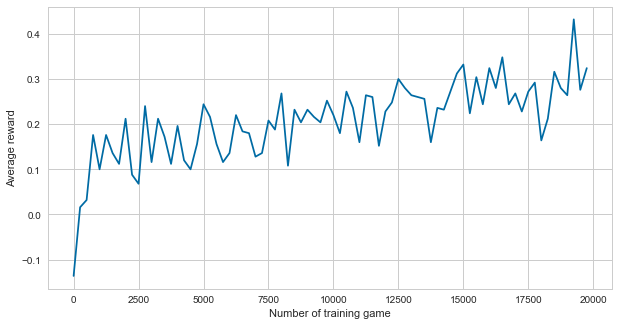

In [155]:
avg_idx = np.arange(20000 // 250)
avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
avg_x = [i * 250 for i in avg_idx]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 4))
    plt.plot(avg_x, avg_rewards)
    plt.xlabel('Number of training game')
    plt.ylabel("Average reward")

### 2.1.1 Decreasing exploration
#### Question 2
Plot average reward for every 250 games during training. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?

#### Question 3
After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents – when measuring the ‘test’ performance, put ε = 0 and do not update the Q-values. Plot Mopt and Mrand over time. Describe the differences and the similarities between these curves and the ones of the previous question.

100%|█████████████████████████████████████| 20000/20000 [08:39<00:00, 38.49it/s]


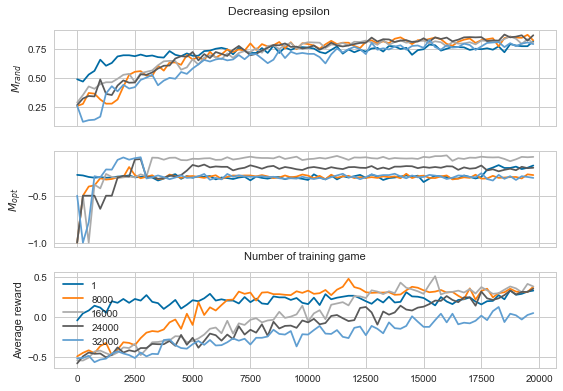

In [159]:
env = TictactoeEnv()

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=3, sharex=True)
with plt.style.context('seaborn-whitegrid'):
    plt.suptitle(f"Decreasing epsilon")
    for n in np.linspace(1, 40000, 5, endpoint=False).astype(int):
        Q, episode_lengths, episode_rewards, Mrands, Mopts = q_learning(env, 20000, 
                                        evaluate_M_values=True, decreasing_eps=True, n_star=n)
        x = [i * 250 for i in range(len(Mrands))]
        avg_idx = np.arange(20000 // 250)
        avg_x = [i * 250 for i in avg_idx]
        avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts)
        ax[2].plot(avg_x, avg_rewards, label=n)
    
    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    ax[2].set_ylabel("Average reward")
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand.png")
    plt.show()

### 2.1.2 Good experts and bad experts
Choose the best value of n∗ that you found in the previous section. Run Q-learning against Opt(ε) for different values of ε for 20’000 games – switch the 1st player after every game. Choose several values of ε from a reasonably wide interval between 0 to 1 – particularly, include ε = 0.

#### Question 4. 
After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents – for each value of εopt. Plot Mopt and Mrand over time. What do you observe? How can you explain it? 

*Expected answer*: A figure showing Mopt and Mrand over time for different values of ε (caption length < 250 words).


100%|█████████████████████████████████████| 20000/20000 [08:27<00:00, 39.38it/s]


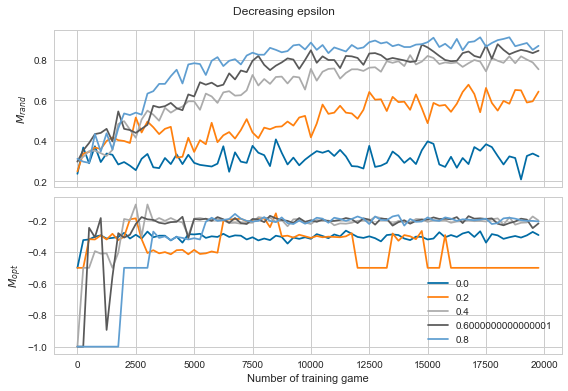

In [161]:
env = TictactoeEnv()

plt.style.use('seaborn-whitegrid')
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    plt.suptitle(f"Decreasing epsilon")
    for eps in np.linspace(0, 1, 5, endpoint=False):
        Q, episode_lengths, episode_rewards, Mrands, Mopts = q_learning(env, 20000, player_epsilon=eps,
                                    evaluate_M_values=True, decreasing_eps=True, n_star=16000)
        avg_x = [i * 250 for i in avg_idx]
        x = [i * 250 for i in range(len(Mrands))]
        avg_idx = np.arange(20000 // 250)
        avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts, label=eps)

    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand_eps.png")
    plt.show()

#### Question 5. 
What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

**Results:** $M_{rand} = 0.9, M_{opt} = 0. $

### 2.2 Learning by self-practice
In this section, your are supposed to ask whether Q-learning can learn to play Tic Tac Toe by only playing against itself. For different values of ε ∈ [0, 1), run a Q-learning agent against itself for 20’000 games – i.e. both players use the same set of Q-values and update the same set of Q-values.

#### Question 7. 
After every 250 games during training, compute the ‘test’ Mopt and Mrand for different values of ε ∈ [0, 1). Does the agent learn to play Tic Tac Toe? What is the effect of ε?

*Expected answer:* A figure showing Mopt and Mrand over time for different values of ε ∈ [0, 1) (caption length < 100 words).

In [162]:
class QTabularActor(): 
    
    def __init__(self):
        self.Q = defaultdict(lambda: np.zeros(9))
        
    #update Q values 
    #grid = before_state, move = action, new_grid = after_state
    def update_q_values(self, grid_p1, move_p1, alpha, discount_factor, new_grid, reward):
        #grid_p1 = get_state(grid_p1, player)
        #new_grid = get_state(new_grid, player)
        value = self.Q[str(grid_p1)][move_p1[0] * 3 + move_p1[1]]
        self.Q[str(grid_p1)][move_p1[0] * 3 + move_p1[1]] += alpha * (reward + discount_factor * np.max(self.Q[str(new_grid)]) - value)
            
    #Select action according to epsilon greedy policy. returns a move
    #eps_min, eps_max, i_episode, num_exploratory_games
    def act(self, grid , eps_min, eps_max, n, num_exploratory_games, fixed_eps_threshold,fixed_epsilon = False): 
        sample = random.random()
        
        #Epsilon update function given in description
        if(fixed_epsilon):
            eps_threshold = fixed_eps_threshold
        else: 
            eps_threshold = max(eps_min, eps_max*(1 - n/num_exploratory_games))       
        
        # greedy 
        possible_moves = np.where(np.ravel(grid) == 0)[0]
        if sample > eps_threshold:
            #grid = get_state(grid, player)
            possible = [int(elem) for elem in np.argsort(self.Q[str(grid)]) if elem in possible_moves]
            position = possible[-1] if possible is not [] else np.random.choice(possible_moves)
        else:
            position = np.random.choice(possible_moves)
            
        return (int(position / 3), position % 3) 

#Flips 1's and -1's between each other in grid.
#def flip_grid(grid):
#    new_grid = np.where(grid == 1, 2, grid)  #replace 1's with 0
#    new_grid =  np.where(grid == -1, 1, new_grid) #replace -1's with 0(remove other players moves)
#    new_grid = np.where(new_grid == 2, -1, new_grid)
#    return new_grid

In [165]:
#Training setup (default settings, this changes slightly depending on question)
NUM_GAMES = 20000   # Description asks to train on 20k games
BATCH_SIZE = 64     # Description sets batch size to 64
GAMMA = 0.99        # Description sets discount factor to 0.99
EPS_MAX = 0.8       # Description suggests this value
EPS_MIN = 0.1       # Description suggests this value
NUM_EXPLORATORY_GAMES = 15000 # Play with this value between [1, 40000], has big impact on how fast we learn
TARGET_UPDATE = 500 # Description: update target_net every 500 games
MEMORY_SIZE = 10000 # Description sets memory size to 10000
OTHER_PLAYER_EPSILON = 0.5
FIXED_EPS_THRESHOLD = 0.3 # Some questions ask for fixed epsilon
FIXED_EPSILON = False  


def self_q_learning(env, num_episodes = NUM_GAMES, discount_factor=0.99, alpha=0.05, fixed_epsilon_threshold=0.3, evaluate_M_values = False, num_exploratory_games = NUM_EXPLORATORY_GAMES,
                    fixed_epsilon = FIXED_EPSILON):
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    Turns = np.array(['X','O'])
    Mopts = []
    Mrands = []

    Qplayer = QTabularActor()

    for i_episode in tqdm(range(num_episodes)):
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode)
        player2_played_once = False

        #if player 2 goes first
        if env.current_player == player2: 
            player2_played_once= True
            grid_p2 = grid
            move_p2 = eps_greedy(Qplayer.Q, str(grid), grid, epsilon = epsilon)
            grid, end, winner = env.step(move_p2, print_grid=False)
        
        while not end:
            if(fixed_epsilon):
                epsilon = fixed_epsilon_threshold
            else:
                epsilon = max(EPS_MIN, EPS_MAX*(1 - i_episode/num_exploratory_games))       
        

            episode_lengths[i_episode] += 1
            
            #move = eps_greedy(Q, str(grid), grid, epsilon=epsilon - epsilon/num_episodes*i_episode)
            
            #player 1 plays
            grid_p1 = grid #store state
            move_p1 = eps_greedy(Qplayer.Q, str(grid), grid, epsilon = epsilon)
            new_grid, end, winner = env.step(move_p1, print_grid=False)

            if player2_played_once:
                Qplayer.update_q_values(grid_p2, move_p2, alpha, discount_factor, new_grid, env.reward(player2))
    
            if end:
                episode_rewards[i_episode] += env.reward(player1)
                Qplayer.update_q_values(grid_p1, move_p1, alpha, discount_factor, new_grid, env.reward(player1))
                break

            #player2 plays 
            player2_played_once=True
            grid_p2 = new_grid
            move_p2 = eps_greedy(Qplayer.Q, str(new_grid), new_grid, epsilon = epsilon)
            new_grid, end, winner = env.step(move_p2, print_grid=False)

            if end:
                Qplayer.update_q_values(grid_p2, move_p2, alpha, discount_factor, new_grid, env.reward(player2))
                break
         
            episode_rewards[i_episode] += env.reward(player1)

            Qplayer.update_q_values(grid_p1, move_p1, alpha, discount_factor, new_grid, env.reward(player1))
            
            grid = new_grid 

        #If want to calculate M values every 250 games
        if(evaluate_M_values == True and (i_episode+1) % 250 == 0):
            Mrand, Mopt = compute_test_Mrand_Mopt(Qplayer.Q)
            Mrands.append(Mrand)
            Mopts.append(Mopt)
    
    print("complete")
    return Qplayer.Q, episode_lengths, episode_rewards, Mrands, Mopts

100%|█████████████████████████████████████| 20000/20000 [09:09<00:00, 36.36it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [09:36<00:00, 34.72it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [08:52<00:00, 37.57it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [09:20<00:00, 35.66it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [08:10<00:00, 40.77it/s]


complete


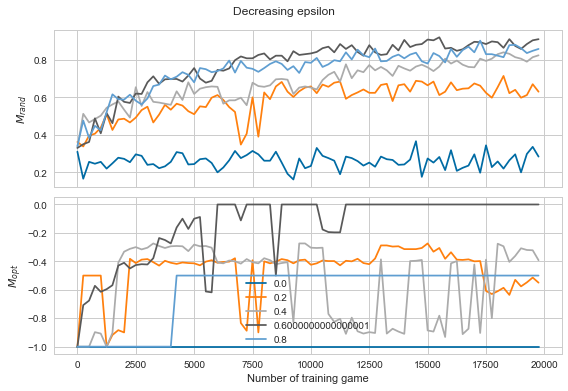

In [166]:
env = TictactoeEnv()

plt.style.use('seaborn-whitegrid')
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    plt.suptitle(f"Decreasing epsilon")
    for eps in np.linspace(0, 1, 5, endpoint=False):
        _, _, _, Mrands, Mopts = self_q_learning(env = env, fixed_epsilon_threshold=eps,
                                                 fixed_epsilon=True ,evaluate_M_values=True) 
        avg_x = [i * 250 for i in avg_idx]
        x = [i * 250 for i in range(len(Mrands))]
        avg_idx = np.arange(20000 // 250)
        avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts, label=eps)

    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand_self_eps.png")
    plt.show()

#### Question 8
After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?

*Expected answer* A figure showing Mopt and Mrand over time for different values of speeds of n∗ (caption length < 100 words).

100%|█████████████████████████████████████| 20000/20000 [09:23<00:00, 35.51it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [08:28<00:00, 39.34it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [08:26<00:00, 39.49it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [08:21<00:00, 39.89it/s]


complete


100%|█████████████████████████████████████| 20000/20000 [08:16<00:00, 40.26it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


complete


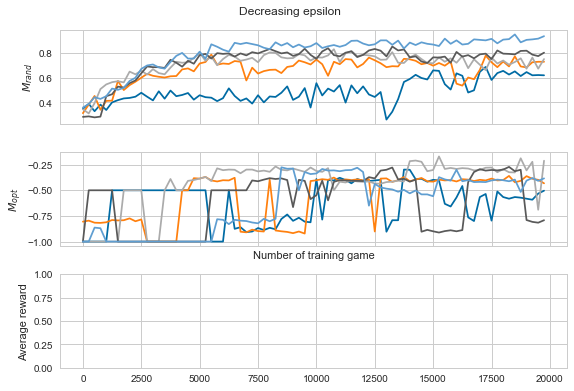

In [168]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=2, sharex=True)
with plt.style.context('seaborn-whitegrid'):
    plt.suptitle(f"Decreasing epsilon")
    for n in np.linspace(1, 40000, 5, endpoint=False).astype(int):
        Q, _, _, Mrands , Mopts  = self_q_learning(env = env, num_episodes = 20000, 
                                num_exploratory_games= n, evaluate_M_values=True, fixed_epsilon=False)
        avg_idx = np.arange(20000 // 250)
        avg_x = [i * 250 for i in avg_idx]
        x = [i * 250 for i in range(len(Mrands))]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts, label=n)
    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand_self_n.png")
    plt.show()

#### Question 9. 

What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

**Results:** $M_{rand} = 0.9, M_{opt} = -0.2 $

#### Question 10. 

For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?

*Expected answer:* A figure with 3 subplots of 3 different states with Q-values shown at available actions (caption length < 200 words).

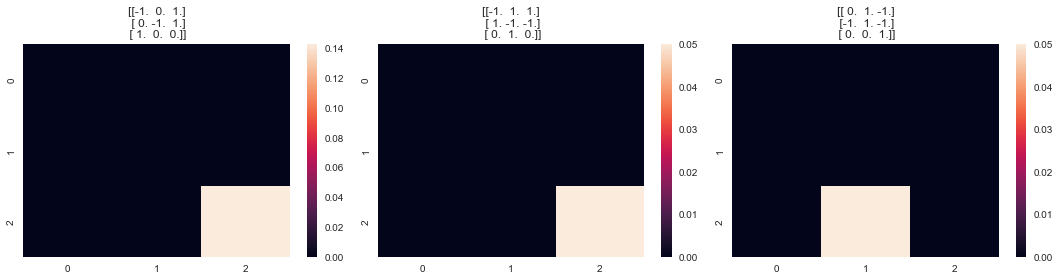

In [176]:
import seaborn as sns 
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
three_elems = list(Q.keys())[-4:-1]
for idx in range(3):
    g = sns.heatmap(Q[three_elems[idx]].reshape((3, 3)), ax=ax[idx])
    g.set_title(three_elems[idx])
plt.tight_layout()

## Deep Q-Learning

In [46]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
#TODO verify plots have the demanded format for the questions, regnerate plots to fit description,
#TODO keep highest values of Mopt and Mrand for question 15, 18
#TODO heatmap question 19, question 12(=/)

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
from itertools import count
import random
from tic_env import TictactoeEnv, OptimalPlayer
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from tqdm import tqdm

#TODO for some reason results not reproducible with just this. maybe need set seed in tic_env
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)

In [30]:
#Helper functions

#Modifies state to specification given in project description.
#Takes a grid and returns a 3x3x2 tensor which contains only values 0 or 1
# such that [:, :, 0] are moves taken by me, [: ,:, 1] moves taken by opponent
def modify_state_to_description(grid, my_turn_sign): 
    if('X' == my_turn_sign): #if i am first player to play
        my_array =  np.where(grid == -1, 0, grid) #replace -1's with 0(remove other players moves)
        other_array = np.where(grid == 1, 0, grid)  #replace 1's with 0
        other_array = np.where(other_array == -1, 1, other_array) 
    else: #-1 = my_moves
        my_array = np.where(grid == 1, 0, grid) #remove other players moves
        my_array = np.where(my_array == -1, 1, my_array) #change -1 to 1's 
        other_array = np.where(grid == -1, 0, grid)
    #print("grid")#print(grid)
    state = np.stack((my_array, other_array))
    #print("state")print(state)
    return state

#Given the state, prepares a tensor for the neural network
def get_tensor_for_neural_net(state):
    state = torch.from_numpy(state)
    state = torch.flatten(state)
    return state.unsqueeze(0).type(torch.float32) 

#Given integer representatin of a move, return tuple representation of move
def get_move_from_position(position):
    move = (int(position / 3), int(position) % 3)
    return move

def move_is_legal(move, grid):
    possible_moves = np.where(np.ravel(grid.ravel()) == 0)[0]   
    return move[0]*3 + move[1] in possible_moves

#first player alternates each game
def assign_players(turns, i_episode):
    if(i_episode > 0):
        turns = np.roll(turns, 1) 
    return turns, turns[0], turns[1]

In [31]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Neural net from description
# (fully connected, 2 hidden layers w 128 neurons each and relu, 3x3x2 inputs and 9 outputs)
# (output layer uses linear activation function)
class Policy(nn.Module):

    def __init__(self, n_inputs=3*3*2, n_outputs=9):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_outputs)

    # From description states are 3 ×3 × 2 tensor where
    # where [:, :, 0] are moves taken by me, [: ,:, 1] moves taken by opponent(here they are flattened)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

    def act(self, state):
        with torch.no_grad():
            output = self.forward(state)
            #print(output)
            return output.max(1)[1].view(1, 1)

In [32]:
class DQNActor(): 
    
    def __init__(self, device, batch_size, gamma, memory_size):
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        
        self.memory = ReplayMemory(memory_size)
        
        self.policy = Policy().to(self.device)
        self.target = Policy().to(self.device)
        self.target.load_state_dict(self.policy.state_dict()) #copy state from policy to target
        self.target.eval() #put into eval state(BN, Dropout ect.. are now turned off)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4) #Description: Adam optimizer with lr = 5e-4

        self.latest_loss = 0
        

    # Taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
       
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
 

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=self.device,
            dtype=torch.bool,
        )

        final = False
        if(self.batch_size == 1):
            if batch.next_state[0] == None:
                final = True
                non_final_next_states = None
            else:
                non_final_next_states = batch.next_state[0]
            state_batch = batch.state[0]
            action_batch = batch.action[0]
            reward_batch = batch.reward[0]
        else:
            non_final_next_states = torch.cat(
                [s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)
        #print(non_final_next_states)
        #print(state_batch)
        #print(action_batch)
        #print(reward_batch)
        #print("=======")
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        #print(final)
        if not final:
            next_state_values[non_final_mask] = self.target(
                non_final_next_states).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        #Store latest loss for plot
        self.latest_loss = loss.detach().numpy().item()

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    #Select action according to epsilon greedy policy.
    def act(self, state: torch.tensor, grid ,eps_min, eps_max, n, num_exploratory_games, fixed_epsilon, fixed_eps_threshold): 
        sample = random.random()
        
        #Epsilon update function given in description
        if(fixed_epsilon):
            eps_threshold = fixed_eps_threshold
        else: 
            eps_threshold = max(eps_min, eps_max*(1 - n/num_exploratory_games))       
        # greedy 
        if sample > eps_threshold:
            with torch.no_grad():
                return get_move_from_position(self.policy.act(state)), 0
        else:
            #Random move must be a valid move
            possible_moves = np.where(np.ravel(grid) == 0)[0]
            position = np.random.choice(possible_moves)
            return get_move_from_position(torch.tensor([[position]],dtype=torch.long)), 1

In [33]:
#Used to evaluate DQN against random and against optimal player

#Given a DQNActor Compute Mopt and Mrand(Defined in project description)
def compute_test_Mrand_Mopt(actor1 : DQNActor):
    n_games = 500
    Mrand = eval_against_optimal_player(actor1, other_player_epsilon = 1., n_games=n_games)
    Mopt = eval_against_optimal_player(actor1, other_player_epsilon = 0., n_games=n_games) 
    return Mrand, Mopt
    
#Evaluate DQNActor over n_games against Optimal player with given epsilon and output (wins-losses)/n_games
def eval_against_optimal_player(actor1: DQNActor , other_player_epsilon, n_games = 500):
    Turns = np.array(['X','O'])
    was_invalid = False
    env = TictactoeEnv()
    losses, wins, invalid_moves, ties = 0, 0, 0 ,0
    for i_episode in range(n_games):
        # Initialize the environment and state
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode) #first player changes every game
        
        other_player = OptimalPlayer(other_player_epsilon, player=player2)
        
        #Loop until game ends
        for t in count():
            #print("grid")#print(grid)#print("state")#print(state)
            state = get_tensor_for_neural_net(modify_state_to_description(np.array(grid, dtype=np.float32), player1))
            #print(state)
            # Select and perform an action
            if env.current_player == player1:
                #No random moves for evaluation(eps_min, num_exploratory games ect.. not used here)
                move, _ = actor1.act(state,  grid, eps_min=0, eps_max=0, n=0, num_exploratory_games=0, fixed_epsilon=True, fixed_eps_threshold=0) 
            else:  
                move = other_player.act(grid)

            if move_is_legal(move, grid) == False:
                end, was_invalid = True, True
            else:
                grid, end, winner = env.step(move, print_grid=False)

            # Observe next state
            if not end:
                next_state = modify_state_to_description(np.array(grid, dtype=np.float32), player1)  
                next_state = get_tensor_for_neural_net(next_state)
            #game has ended
            else:
                #count wins losses
                if was_invalid == False:
                    if winner == player1: 
                        wins += 1 
                    elif str(winner) == "None":
                        ties += 1
                    else:
                        losses += 1
                else: 
                    invalid_moves += 1 #Dont care about invalid moves for this evaluation
                was_invalid = False #reset boolean
                next_state = None #because finish game

            # Move to the next state
            state = next_state
            
            if end:
                break
    
    #print("wins: " + str(wins) + ", losses: " + str(losses) + ", ties: " + str(ties) + ", invalid moves: " + str(invalid_moves))
    return (wins - losses)/(n_games)

In [34]:
#Training

#Training setup (default settings, this changes slightly depending on question)
NUM_GAMES = 20000 # Description asks to train on 20k games
BATCH_SIZE = 64     # Description sets batch size to 64
GAMMA = 0.99        # Description sets discount factor to 0.99
EPS_MAX = 0.8       # Description suggests this value
EPS_MIN = 0.1       # Description suggests this value
NUM_EXPLORATORY_GAMES = 15000 # Play with this value between [1, 40000], has big impact on how fast we learn
TARGET_UPDATE = 500 # Description: update target_net every 500 games
MEMORY_SIZE = 10000 # Description sets memory size to 10000
OTHER_PLAYER_EPSILON = 0.5
FIXED_EPS_THRESHOLD = 0.3 # Some questions ask for fixed epsilon
FIXED_EPSILON = False     


def train(num_games = NUM_GAMES, batch_size = BATCH_SIZE, gamma = GAMMA, eps_max = EPS_MAX, 
    eps_min = EPS_MIN, num_exploratory_games = NUM_EXPLORATORY_GAMES, target_update = TARGET_UPDATE, 
    memory_size = MEMORY_SIZE, other_player_epsilon = OTHER_PLAYER_EPSILON, 
    fixed_eps_threshold = FIXED_EPS_THRESHOLD, fixed_epsilon = FIXED_EPSILON, evaluate_M_values = False
    ):

    wins, ties, loses, invalid_moves, random_moves, total_moves_player_1 = 0, 0, 0, 0, 0, 0
    was_invalid = False
    Turns = np.array(['X','O'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    actor1 = DQNActor(device = device, batch_size = batch_size, gamma = gamma, memory_size = memory_size);

    env = TictactoeEnv()

    #Keep track of reward and losses for plots
    episode_durations = []
    rewards = []
    losses = [] 
    Mopts = []
    Mrands = []

    # Main Training loop
    # Train over a number of games
    for i_episode in range(num_games):
    
        # Initialize the environment and state
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode) #first player changes every game 
        #player1 = Turns[0]
        #player2 = Turns[1]
        actor2 = OptimalPlayer(epsilon=other_player_epsilon, player=player2)

        #If player 2 plays first, we let him play once before starting loop.
        if(env.current_player == player2):
            grid, end, winner = env.step(actor2.act(grid), print_grid=False)
            #get reward for player1 after player2 plays
            reward = env.reward(player1) 
        
        #Loop until game ends
        for t in count():
            #print("grid")#print(grid)#print("state")#print(state)
            
            state = get_tensor_for_neural_net(modify_state_to_description(np.array(grid, dtype=np.float32), player1))
            
            # Player1 plays
            move, rand = actor1.act(state, grid, eps_min, eps_max, i_episode, num_exploratory_games, fixed_epsilon, fixed_eps_threshold) 
            random_moves += rand
            total_moves_player_1  += 1

            #From description: if move puts us in an illegal state, we end and give reward = -1.
            #(instead of forcing player to make legal moves)
            if move_is_legal(move, grid) == False:
                #print("not possible move")
                reward = -1
                end, was_invalid = True, True
            else:
                #play move and get reward (Does it make sense to store also other players moves? )
                grid, end, winner = env.step(move, print_grid=False)
                reward = env.reward(player1) 

            # Player2 plays 
            if not end:
                grid, end, winner = env.step(actor2.act(grid), print_grid=False)
                #get reward for player1 after player2 plays
                reward = env.reward(player1) 
            
            #Observe next state
            if not end:
                next_state = modify_state_to_description(np.array(grid, dtype=np.float32), player1)  #probably should be player 1 here
                next_state = get_tensor_for_neural_net(next_state)
            
            #game has ended
            else:
                #count wins losses ties 
                if was_invalid == False:
                    if winner == player1: 
                        wins += 1 
                    elif str(winner) == "None":
                        ties += 1
                    else:
                        loses += 1
                else: 
                    invalid_moves += 1
                was_invalid = False #reset boolean
                next_state = None #because finish game
        
            # Store the transition in memory
            action = torch.tensor([[move[0] * 3 + move[1]]]) #move
            actor1.memory.push(state, action, next_state, torch.tensor([reward]))
        
            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network) of given actors
            actor1.optimize_model()
            
            if end:
                episode_durations.append(t + 1)
                rewards.append(reward)
                losses.append(actor1.latest_loss)
                break
        
        # Update the target network(s), copying all weights and biases in DQN
        if i_episode % target_update == 0:
            actor1.target.load_state_dict(actor1.policy.state_dict())
        
        # Evaluate training
        if (i_episode+1) % 5000 == 0 and i_episode != 1:
            print("For batch of 5000 games: " + " Wins: " + str(wins) + ", Losses: " + str(loses) +
                ", Ties: " + str(ties) + " Invalid moves: " + str(invalid_moves)
                + ", Percentage of random moves: " + str(random_moves/total_moves_player_1))
            wins, ties, loses, invalid_moves, random_moves, total_moves_player_1 = 0, 0, 0, 0, 0, 0 
        
        #If want to calculate M values every 250 games
        if(evaluate_M_values == True and (i_episode+1) % 250 == 0 and i_episode != 1):
            Mrand, Mopt = compute_test_Mrand_Mopt(actor1)
            Mrands.append(Mrand)
            Mopts.append(Mopt)
    
    print('Complete')
    return rewards, losses, Mrands, Mopts

#### Question 11. 

Plot average reward and average training loss for every 250 games during training. Does the loss decrease? Does the agent learn to play Tic Tac Toe?

In [ ]:
env = TictactoeEnv()

plt.style.use('seaborn-whitegrid')
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    plt.suptitle(f"Decreasing epsilon")
    for eps in np.linspace(0, 1, 5, endpoint=False):
        _, _, _, Mrands, Mopts = self_q_learning(env = env, fixed_epsilon_threshold=eps,
                                                 fixed_epsilon=True ,evaluate_M_values=True) 
        avg_x = [i * 250 for i in avg_idx]
        x = [i * 250 for i in range(len(Mrands))]
        avg_idx = np.arange(20000 // 250)
        avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts, label=eps)

    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand_self_eps.png")
    plt.show()

For batch of 5000 games:  Wins: 2412, Losses: 1155, Ties: 1175 Invalid moves: 258, Percentage of random moves: 0.10177357865075419
For batch of 5000 games:  Wins: 3029, Losses: 645, Ties: 1269 Invalid moves: 57, Percentage of random moves: 0.10367929115565401
For batch of 5000 games:  Wins: 2943, Losses: 637, Ties: 1347 Invalid moves: 73, Percentage of random moves: 0.10012871393328328
For batch of 5000 games:  Wins: 2967, Losses: 611, Ties: 1350 Invalid moves: 72, Percentage of random moves: 0.09895666986053445
Complete


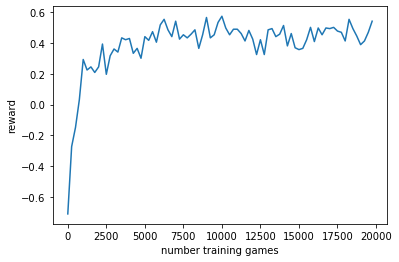

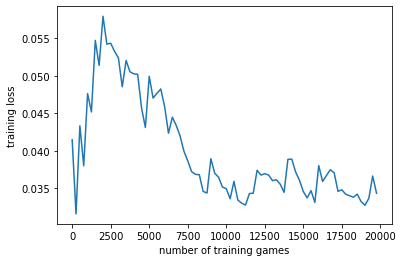

In [27]:
#choice of epsilon
fixed_eps_threshold = 0.1

rewards, losses, _ , _ = train(other_player_epsilon = 0.5, fixed_epsilon=True, fixed_eps_threshold=fixed_eps_threshold) 
#Plot average reward and losses for every 250 games during training
n = 250 # Average over sets of 250 games
avg_rewards = np.average(np.array(rewards).reshape(-1, n), axis=1)
x = [i*250 for i in range(len(avg_rewards))]
avg_losses = np.average(np.array(losses).reshape(-1, n), axis=1)

with plt.style.context('seaborn-whitegrid'):
    plt.plot(x, avg_rewards, label="Reward")
    plt.xlabel('Number of training games') 
    plt.ylabel('Value') 
    plt.plot(x, avg_losses, label="Loss")
    plt.savefig('question11_loss_reward.png', bbox_inches='tight')
    plt.show()

#### Question 12. 

Repeat the training but without the replay buffer and with a batch size of 1: At every step, update the network by using only the latest transition. What do you observe?

In [13]:
#Note: Modified optimizer to handle batch_size = 1, seperately.
fixed_eps_threshold = 0.1 #Make sure its same used in Question 11 for comparison
rewards, losses, _ , _ = train(memory_size = 1, batch_size = 1, fixed_epsilon=True, fixed_eps_threshold=fixed_eps_threshold, num_games=20000) 
#Plot average reward and losses for every 250 games during training
n = 250 # Average over sets of 250 games
avg_rewards = np.average(np.array(rewards).reshape(-1, n), axis=1)
x = [i*250 for i in range(len(avg_rewards))]
avg_losses = np.average(np.array(losses).reshape(-1, n), axis=1)

with plt.style.context('seaborn-whitegrid'):
    plt.plot(x, avg_rewards, label="Reward")
    plt.xlabel('Number of training games') 
    plt.ylabel('Value') 
    plt.plot(x, avg_losses, label="Loss")
    plt.savefig('question12_loss_reward.png', bbox_inches='tight')
    plt.show()

NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:21063 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:29726 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:1258 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradMLC: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_3.cpp:11220 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at ../aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


#### Question 13. 

After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=2, sharex=True)
with plt.style.context('seaborn-whitegrid'):
    plt.suptitle(f"Decreasing epsilon")
    for n in np.linspace(1, 40000, 5, endpoint=False).astype(int):
        _, _, Mrands , Mopts  = train(other_player_epsilon = 0.5, num_games = 20000, 
                                      num_exploratory_games= n, evaluate_M_values=True) 
        avg_x = [i * 250 for i in avg_idx]
        x = [i * 250 for i in range(len(Mrands))]
        avg_idx = np.arange(20000 // 250)
        avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts, label=n)
    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand_dqn_n.png")
    plt.show()

For batch of 5000 games:  Wins: 2416, Losses: 1191, Ties: 1139 Invalid moves: 254, Percentage of random moves: 0.09787021075460157
For batch of 5000 games:  Wins: 3064, Losses: 629, Ties: 1244 Invalid moves: 63, Percentage of random moves: 0.10467058126380434
For batch of 5000 games:  Wins: 2900, Losses: 640, Ties: 1386 Invalid moves: 74, Percentage of random moves: 0.0999091249264981
For batch of 5000 games:  Wins: 3006, Losses: 633, Ties: 1286 Invalid moves: 75, Percentage of random moves: 0.10182949729062718
Complete


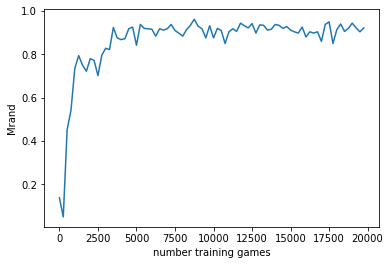

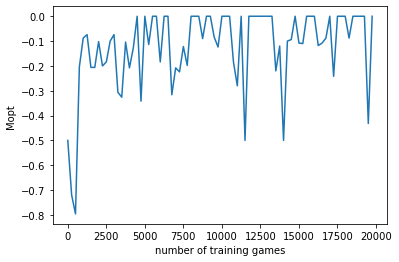

For batch of 5000 games:  Wins: 1542, Losses: 2481, Ties: 838 Invalid moves: 139, Percentage of random moves: 0.6006924736065388
For batch of 5000 games:  Wins: 2615, Losses: 1067, Ties: 1265 Invalid moves: 53, Percentage of random moves: 0.2183895655923251
For batch of 5000 games:  Wins: 2992, Losses: 671, Ties: 1269 Invalid moves: 68, Percentage of random moves: 0.09797315364457992
For batch of 5000 games:  Wins: 2901, Losses: 653, Ties: 1369 Invalid moves: 77, Percentage of random moves: 0.10129127857747672
Complete


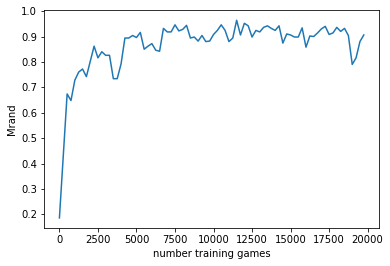

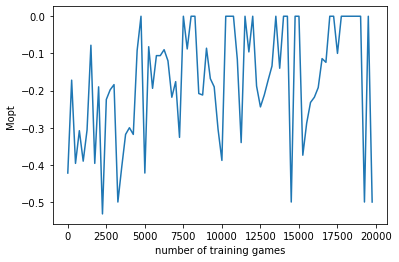

For batch of 5000 games:  Wins: 1412, Losses: 2710, Ties: 736 Invalid moves: 142, Percentage of random moves: 0.7028293798228065
For batch of 5000 games:  Wins: 1942, Losses: 1990, Ties: 1008 Invalid moves: 60, Percentage of random moves: 0.49694063171820735
For batch of 5000 games:  Wins: 2386, Losses: 1420, Ties: 1130 Invalid moves: 64, Percentage of random moves: 0.30271906589545383
For batch of 5000 games:  Wins: 2903, Losses: 680, Ties: 1346 Invalid moves: 71, Percentage of random moves: 0.12711508145034156
Complete


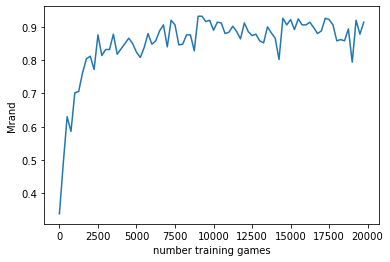

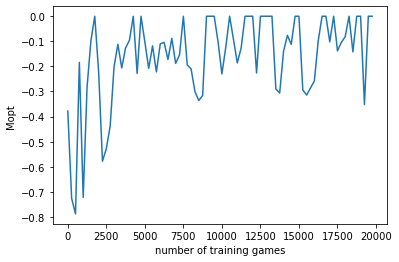

For batch of 5000 games:  Wins: 1390, Losses: 2706, Ties: 787 Invalid moves: 117, Percentage of random moves: 0.7290956600772551
For batch of 5000 games:  Wins: 1698, Losses: 2335, Ties: 922 Invalid moves: 45, Percentage of random moves: 0.605003621775227
For batch of 5000 games:  Wins: 1973, Losses: 1919, Ties: 1046 Invalid moves: 62, Percentage of random moves: 0.46538398289754973
For batch of 5000 games:  Wins: 2373, Losses: 1489, Ties: 1050 Invalid moves: 88, Percentage of random moves: 0.33224967490247076
Complete


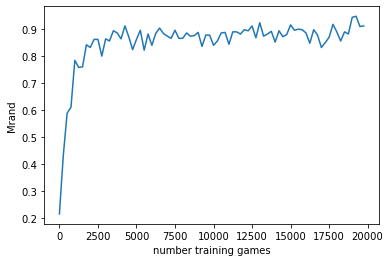

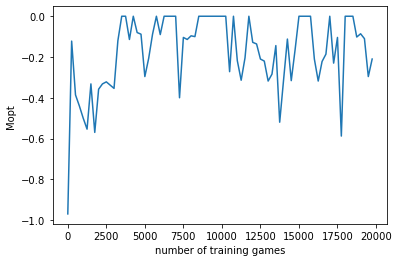

For batch of 5000 games:  Wins: 1345, Losses: 2820, Ties: 715 Invalid moves: 120, Percentage of random moves: 0.7446503356089725
For batch of 5000 games:  Wins: 1600, Losses: 2440, Ties: 889 Invalid moves: 71, Percentage of random moves: 0.650019617734432
For batch of 5000 games:  Wins: 1738, Losses: 2265, Ties: 931 Invalid moves: 66, Percentage of random moves: 0.550665701075149
For batch of 5000 games:  Wins: 1948, Losses: 1981, Ties: 1004 Invalid moves: 67, Percentage of random moves: 0.44927695606752077
Complete


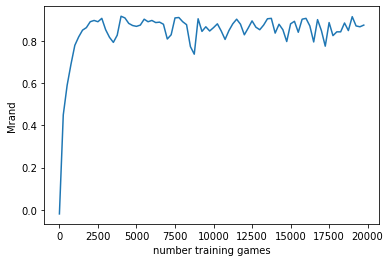

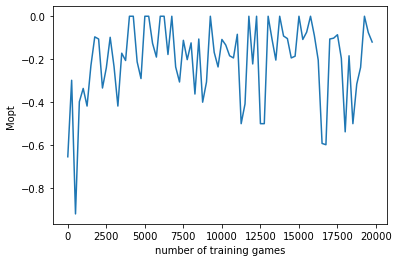

In [11]:
# n_stars = [1, 10000, 20000, 30000, 40000] #TODO could add more 5k, 15k,25k, 35k
# for n_star in n_stars:
#     _, _, Mrands , Mopts  = train(other_player_epsilon = 0.5, num_games = 20000, num_exploratory_games= n_star, evaluate_M_values=True) 
#     #Plot average reward and losses for every 250 games during training
#     n = 250 # Average over sets of 250 games
#     x = [i*250 for i in range(len(Mrands))]
#     plot1 = plt.figure(1)
#     plt.plot(x, Mrands, label = str(n_star))
   
#     plot2 = plt.figure(2)
#     plt.plot(x, Mopts, label = str(n_star))

 
# plot1 = plt.figure(1)
# plt.xlabel('number training games') 
# plt.ylabel('Mrand values')
# plt.legend()
# plt.savefig('question13_Mrands'+'.png', bbox_inches='tight')
# plot2 = plt.figure(2)
# plt.xlabel('number of training games')
# plt.ylabel('Mopt values')
# plt.legend()
# plt.savefig('question13_Mopts'+'.png', bbox_inches='tight')
# plt.show()

#### Question 14. 

After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents 4 for each value of εopt. Plot Mopt and Mrand over time. What do you observe? How can you explain it? Expected answer: A figure showing Mopt and Mrand over time for different values of εopt (caption length < 250 words).


In [ ]:
best_n_star = 1
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=2, sharex=True)
with plt.style.context('seaborn-whitegrid'):
    plt.suptitle(f"Decreasing epsilon")
    for eps in np.linspace(0, 1, 5, endpoint=False):
         _, _, Mrands , Mopts  = train(other_player_epsilon = eps, num_games = 20000, 
                                       num_exploratory_games= best_n_star, evaluate_M_values=True) 
    
        avg_x = [i * 250 for i in avg_idx]
        x = [i * 250 for i in range(len(Mrands))]
        avg_idx = np.arange(20000 // 250)
        avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts, label=eps)
    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand_question14.png")
    plt.show()

For batch of 5000 games:  Wins: 0, Losses: 974, Ties: 3763 Invalid moves: 263, Percentage of random moves: 0.09986117095121834
For batch of 5000 games:  Wins: 0, Losses: 710, Ties: 4223 Invalid moves: 67, Percentage of random moves: 0.09536058366850622
For batch of 5000 games:  Wins: 0, Losses: 747, Ties: 4188 Invalid moves: 65, Percentage of random moves: 0.09999532076177998
For batch of 5000 games:  Wins: 0, Losses: 715, Ties: 4235 Invalid moves: 50, Percentage of random moves: 0.09957498482088646
Complete
For batch of 5000 games:  Wins: 1049, Losses: 1204, Ties: 2429 Invalid moves: 318, Percentage of random moves: 0.09869264291207383
For batch of 5000 games:  Wins: 1383, Losses: 853, Ties: 2654 Invalid moves: 110, Percentage of random moves: 0.10363086232980333
For batch of 5000 games:  Wins: 1619, Losses: 791, Ties: 2516 Invalid moves: 74, Percentage of random moves: 0.0976395389803211
For batch of 5000 games:  Wins: 1741, Losses: 716, Ties: 2463 Invalid moves: 80, Percentage of ra

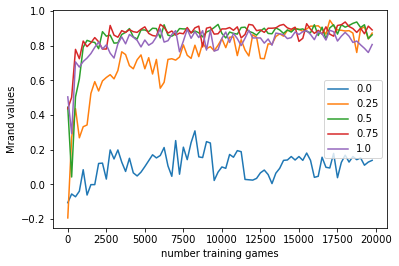

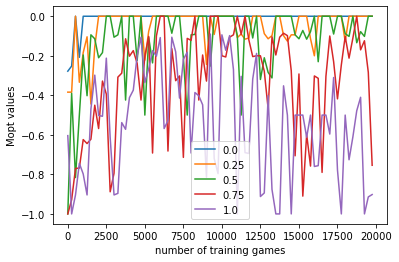

In [17]:
# best_n_star = 1
# other_eps = [0., 0.25, 0.5, 0.75, 1.] 
# for eps in other_eps:
#     _, _, Mrands , Mopts  = train(other_player_epsilon = eps, num_games = 20000, num_exploratory_games= best_n_star, evaluate_M_values=True) 
#     #Plot average reward and losses for every 250 games during training
#     n = 250 # Average over sets of 250 games
#     x = [i*250 for i in range(len(Mrands))]
#     plot1 = plt.figure(1)
#     plt.plot(x, Mrands, label = str(eps))
    
#     plot2 = plt.figure(2)
#     plt.plot(x, Mopts, label = str(eps))  

# plot1 = plt.figure(1)
# plt.xlabel('number training games') 
# plt.ylabel('Mrand values')
# plt.legend()
# plt.savefig('question14_Mrands'+'.png', bbox_inches='tight')
# plot2 = plt.figure(2)
# plt.xlabel('number of training games')
# plt.ylabel('Mopt values')
# plt.legend()
# plt.savefig('question14_Mopts'+'.png', bbox_inches='tight')
# plt.show()

# TODO 
#### Question 15: 

What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

### 3.3 Learning by self-practice
For different values of ε ∈ [0, 1), run a DQN agent against itself for 20’000 games – i.e. both players use the same neural network and share the same replay buffer. Important note: For one player, you should add states st and st′ as x t and x tp to the replay buffer, but for the other player, you should first swap the opponent positions (x t[:,:,1] and x tp[:,:,1]) with the agent’s own positions (x t[:,:,0] and x tp[:,:,0]) and then add them to the replay buffer.

In [8]:
#Training setup (default settings, this changes slightly depending on question)
NUM_GAMES = 20000 # Description asks to train on 20k games
BATCH_SIZE = 64     # Description sets batch size to 64
GAMMA = 0.99        # Description sets discount factor to 0.99
EPS_MAX = 0.8       # Description suggests this value
EPS_MIN = 0.1       # Description suggests this value
NUM_EXPLORATORY_GAMES = 15000 # Play with this value between [1, 40000], has big impact on how fast we learn
TARGET_UPDATE = 500 # Description: update target_net every 500 games
MEMORY_SIZE = 10000 # Description sets memory size to 10000
OTHER_PLAYER_EPSILON = 0.5
FIXED_EPS_THRESHOLD = 0.3 # Some questions ask for fixed epsilon
FIXED_EPSILON = False     


def self_train(num_games = NUM_GAMES, batch_size = BATCH_SIZE, gamma = GAMMA, eps_max = EPS_MAX, 
    eps_min = EPS_MIN, num_exploratory_games = NUM_EXPLORATORY_GAMES, target_update = TARGET_UPDATE, 
    memory_size = MEMORY_SIZE, other_player_epsilon = OTHER_PLAYER_EPSILON, 
    fixed_eps_threshold = FIXED_EPS_THRESHOLD, fixed_epsilon = FIXED_EPSILON, evaluate_M_values = False
    ):

    Turns = np.array(['X','O'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    actor = DQNActor(device = device, batch_size = batch_size, gamma = gamma, memory_size = memory_size);

    env = TictactoeEnv()

    #Keep track of reward and losses for plots
    episode_durations = []
    rewards = []
    losses = [] 
    Mopts = []
    Mrands = []

    # Main Training loop
    # Train over a number of games
    #TODO alternate players first player for self training
    for i_episode in range(num_games):
    
        # Initialize the environment and state
        env.reset()
        grid, end, winner = env.observe()
        Turns, player1, player2 = assign_players(Turns, i_episode) #first player changes every game 


        player_2_played = False
        if(env.current_player == player2):
            player_2_played = True
            state_p2 = get_tensor_for_neural_net(modify_state_to_description(np.array(grid, dtype=np.float32), player2))
            move_p2, _ = actor.act(state_p2, grid, eps_min, eps_max, i_episode, num_exploratory_games, fixed_epsilon, fixed_eps_threshold) 
            #get reward for player1 after player2 plays
            if move_is_legal(move_p2, grid) == False:
                reward_p2 = -1
                end = True
            else:
                grid, end, winner = env.step(move_p2, print_grid=False)
                reward_p1 = env.reward(player1) 
                reward_p2 = env.reward(player2) 


        #Loop until game ends
        for t in count():
            #print("grid")#print(grid)#print("state")#print(state)
            
            state_p1 = get_tensor_for_neural_net(modify_state_to_description(np.array(grid, dtype=np.float32), player1))
            
            # Player1 plays
            move_p1, _ = actor.act(state_p1, grid, eps_min, eps_max, i_episode, num_exploratory_games, fixed_epsilon, fixed_eps_threshold) 

            #From description: if move puts us in an illegal state, we end and give reward = -1.
            #(instead of forcing player to make legal moves)
            if move_is_legal(move_p1, grid) == False:
                reward_p1 = -1
                end = True
            else:
                grid, end, winner = env.step(move_p1, print_grid=False)
                reward_p1 = env.reward(player1) 
                reward_p2 = env.reward(player2) 

            #Observe next state
            if not end:
                next_state = modify_state_to_description(np.array(grid, dtype=np.float32), player2) 
                next_state = get_tensor_for_neural_net(next_state)
            else:
                next_state = None #because finish game

            if player_2_played: #only push player 2 played has played a move before
                # Store player2 transition in memory
                action = torch.tensor([[move_p2[0] * 3 + move_p2[1]]]) #move
                actor.memory.push(state_p2, action, next_state, torch.tensor([reward_p2]))

            # Player2 plays 
            if not end:
                player_2_played = True
                state_p2 = get_tensor_for_neural_net(modify_state_to_description(np.array(grid, dtype=np.float32), player2))
                move_p2, rand = actor.act(state_p2, grid, eps_min, eps_max, i_episode, num_exploratory_games, fixed_epsilon, fixed_eps_threshold) 

                if move_is_legal(move_p2, grid) == False:
                    reward_p2 = -1
                    end = True
                else:
                    #play move and get reward (Does it make sense to store also other players moves? )
                    grid, end, winner = env.step(move_p2, print_grid=False)
                    reward_p1 = env.reward(player1) 
                    reward_p2 = env.reward(player2) 
            
            #Observe next state
            if not end:
                next_state = modify_state_to_description(np.array(grid, dtype=np.float32), player1) 
                next_state = get_tensor_for_neural_net(next_state)
            else:
                next_state = None #because finish game
            
            # Store player1 transition in memory
            action = torch.tensor([[move_p1[0] * 3 + move_p1[1]]]) #move
            actor.memory.push(state_p1, action, next_state, torch.tensor([reward_p1]))  

            # Perform one step of the optimization (on the policy network)
            actor.optimize_model()
            
            if end:
                episode_durations.append(t + 1)
                rewards.append(reward_p1)
                losses.append(actor.latest_loss)
                break
        
        # Update the target network(s), copying all weights and biases in DQN
        if i_episode % target_update == 0:
            actor.target.load_state_dict(actor.policy.state_dict())
        
        #If want to calculate M values every 250 games
        if(evaluate_M_values == True and (i_episode+1) % 250 == 0 and i_episode != 1):
            Mrand, Mopt = compute_test_Mrand_Mopt(actor)
            Mrands.append(Mrand)
            Mopts.append(Mopt)
    
    print('Complete')
    return rewards, losses, Mrands, Mopts

#### Question 16. 

After every 250 games during training, compute the ‘test’ Mopt and Mrand for different values of ε ∈ [0, 1). Plot Mopt and Mrand over time. Does the agent learn to play Tic Tac Toe? What is the effect of ε?

In [ ]:
best_n_star = 1
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=3, sharex=True)
with plt.style.context('seaborn-whitegrid'):
    plt.suptitle(f"Decreasing epsilon")
    for eps in np.linspace(0, 1, 5, endpoint=True):
         _, _, Mrands , Mopts  = train(other_player_epsilon = eps, num_games = 20000, 
                                       num_exploratory_games= best_n_star, evaluate_M_values=True) 
    
        avg_x = [i * 250 for i in avg_idx]
        x = [i * 250 for i in range(len(Mrands))]
        avg_idx = np.arange(20000 // 250)
        avg_rewards = [np.mean(episode_rewards[250 * i: 250 * (i + 1)]) for i in avg_idx]
        
        ax[0].plot(x, Mrands)
        ax[1].plot(x, Mopts, label=eps)
    
    ax[1].set_xlabel('Number of training game') 
    ax[0].set_ylabel(r'$M_{rand}$')
    ax[1].set_ylabel(r'$M_{opt}$')    
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Mopt_Mrand_question14.png")
    plt.show()

Complete
Complete
Complete
Complete
Complete
Complete


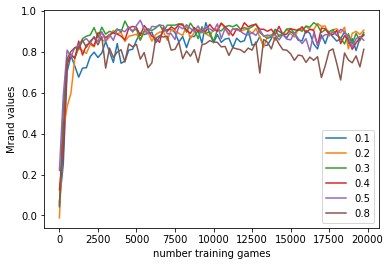

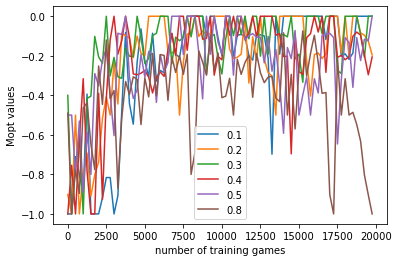

In [16]:
fixed_eps_thresholds = [0.1, 0.2, 0.3, 0.5, 0.8]
for eps in fixed_eps_thresholds:
    with plt.style.context('seaborn-whitegrid'):
        rewards, losses, Mrands , Mopts = self_train(fixed_epsilon=True, fixed_eps_threshold=eps, evaluate_M_values=True) 
        #Plot average reward and losses for every 250 games during training
        n = 250 # Average over sets of 250 games
        avg_rewards = np.average(np.array(rewards).reshape(-1, n), axis=1)
        x = [i*250 for i in range(len(avg_rewards))]
        #Code for seeing rewards and losses if interrested
        #plt.plot(x, avg_rewards)
        #plt.xlabel('number training games') 
        #plt.ylabel('reward')
        #plt.savefig('question16_reward_' + str(fixed_eps_threshold) +'.png', bbox_inches='tight')
        #plt.show()
        #avg_losses = np.average(np.array(losses).reshape(-1, n), axis=1) 
        #x = [i*250 for i in range(len(avg_losses))]
        #plt.plot(x, avg_losses)
        #plt.xlabel('number of training games')
        #plt.ylabel('training loss')
        #plt.savefig('question16_loss_' + str(fixed_eps_threshold) + '.png', bbox_inches='tight')
        #plt.show()

        x = [i*250 for i in range(len(Mrands))]
        plot1 = plt.figure(1)
        plt.plot(x, Mrands, label = str(eps))

        plot2 = plt.figure(2)
        plt.plot(x, Mopts, label = str(eps))
   

plot1 = plt.figure(1)
plt.xlabel('Number training games') 
plt.ylabel('Mrand values')
plt.legend()
plt.savefig('question16_Mrands.png', bbox_inches='tight')
plot2 = plt.figure(2)
plt.xlabel('Number of training games')
plt.ylabel('Mopt values')
plt.legend()
plt.savefig('question16_Mopts.png', bbox_inches='tight')
#plt.savefig('question16_Mopts_' + str("") + '.png', bbox_inches='tight')
plt.show()

#### Question 17. 

After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?

In [ ]:
n_star_vals = [1, 10000, 20000, 30000, 40000]
for n_star in n_star_vals:
    rewards, losses, Mrands , Mopts = self_train(num_exploratory_games=n_star, evaluate_M_values=True) 
    #Plot average reward and losses for every 250 games during training
    n = 250 # Average over sets of 250 games
    avg_rewards = np.average(np.array(rewards).reshape(-1, n), axis=1)
    x = [i*250 for i in range(len(avg_rewards))]
    #Code for seeing rewards and losses if interrested
    #plt.plot(x, avg_rewards)
    #plt.xlabel('number training games') 
    #plt.ylabel('reward')
    #plt.savefig('question16_reward_' + str(fixed_eps_threshold) +'.png', bbox_inches='tight')
    #plt.show()
    #avg_losses = np.average(np.array(losses).reshape(-1, n), axis=1) 
    #x = [i*250 for i in range(len(avg_losses))]
    #plt.plot(x, avg_losses)
    #plt.xlabel('number of training games')
    #plt.ylabel('training loss')
    #plt.savefig('question16_loss_' + str(fixed_eps_threshold) + '.png', bbox_inches='tight')
    #plt.show()

    x = [i*250 for i in range(len(Mrands))]
    plot1 = plt.figure(1)
    plt.plot(x, Mrands, label = str(n_star))
    
    plot2 = plt.figure(2)
    plt.plot(x, Mopts, label = str(n_star))


plot1 = plt.figure(1)
plt.xlabel('number training games') 
plt.ylabel('Mrand values')
plt.legend()
plt.savefig('question16_Mrands'+'.png', bbox_inches='tight')
plot2 = plt.figure(2)
plt.xlabel('number of training games')
plt.ylabel('Mopt values')
plt.legend()
plt.savefig('question16_Mopts'+'.png', bbox_inches='tight')
#plt.savefig('question16_Mopts_' + str("") + '.png', bbox_inches='tight')
plt.show()

#### Question 18. 
What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

# todo 
#### Question 19. 
For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?

## Comparing Q-Learning with Deep Q-Learning
We define the training time Ttrain as the number of games an algorithm needs to play in order to reach 80% of its final performance according to both Mopt and Mrand.

In [ ]:
def dqn_eval(other_player_epsilon=0.5, games=20000):
    total_reward = []
    env.reset()
    Turns = np.array(['X','O'])
    count_win, none_win, loose = 0, 0, 0 
    winner_list = [] 
    for i in tqdm(range(games)):
        grid, end, winner = env.observe()
        
        player = OptimalPlayer(epsilon=other_player_epsilon, player=Turns[1])
        while not end:
            if env.current_player == Turns[0]:
                state = modify_state_to_description(np.array([[grid]], dtype=np.int32), Turns[0])
                state = torch.from_numpy(state)
                # Resize, and add a batch dimension (BCHW)
                state = state.unsqueeze(0).type(torch.float32) #mmh suspicious
                position = select_model_action(policy, state)
                move = (int(position / 3), int(position) % 3)
            else:  
                move = player.act(grid)
            #at this point should not be making invalid moves... because player has trained
            grid, end, winner = env.step(move, print_grid=False)
            total_reward.append(env.reward(env.current_player))
            
            if end:
                if winner == Turns[0]: 
                    count_win += 1 
                elif str(winner) == "None":
                    none_win += 1
                else:
                    loose += 1
#                 print('-------------------------------------------')
#                 print('Game end, winner is player ' + str(winner))
#                 print('Q-Learning player = ', Turns[0])
#                 print(f'Another player with epsilon {other_player_epsilon} = ', Turns[1])
        #             env.render()
                env.reset()
                break
    return count_win / games, none_win / games, loose / games, np.mean(total_reward)


In [ ]:
score = dqn_eval(0.5, 1000)
print(f"Wins of DQN: {score[0]}, wins None: {score[1]}, wins Another player: {score[2]}") 